# Downloading Data From Kaggle

In [66]:
 ! pip install -q kaggle

In [67]:
from google.colab import files

In [68]:
files.upload()



{}

In [69]:
import os
os.getcwd()

'/content'

In [70]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [71]:
!chmod 600 ~/.kaggle/kaggle.json

In [72]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content'

In [73]:
!kaggle datasets download -d olekslu/makeup-lips-segmentation-28k-samples

User cancelled operation


# Extracting Data

In [74]:
from zipfile import ZipFile
import os

zip_file_path = os.path.join(os.getcwd(),'makeup-lips-segmentation-28k-samples.zip')
zip_ref = ZipFile(zip_file_path, 'r')
extract_path = os.path.join(os.getcwd(), 'lip')

zip_ref.extractall(extract_path)
zip_ref.close()

KeyboardInterrupt: ignored

In [ ]:
home_directory = os.path.join(os.getcwd(),'lip','set-lipstick-original')

current_train_directory_path = os.path.join(home_directory, '720p')
current_mask_directory_path = os.path.join(home_directory, 'mask')

dir_train_frame = os.path.join(os.getcwd(), 'lip','train_frames','train')
dir_train_mask  = os.path.join(os.getcwd(), 'lip','train_masks', 'train')
dir_val_frame   = os.path.join(os.getcwd(), 'lip','val_frames', 'val')
dir_val_mask    = os.path.join(os.getcwd(), 'lip','val_masks', 'val')

os.makedirs(dir_train_frame)
os.makedirs(dir_train_mask)
os.makedirs(dir_val_frame)
os.makedirs(dir_val_mask)

# Renaming File

In [ ]:
import re
def rename_directory_content(path):
    for fname in os.listdir(path):
        new_name_l = re.split('(\d+)',fname)
        
        new_name = new_name_l[1] + new_name_l[2] 
        old_path = os.path.join(path, fname)
        new_path = os.path.join(path, new_name)

        os.rename(old_path, new_path)

rename_directory_content(current_train_directory_path)
rename_directory_content(current_mask_directory_path)

# Finding (Frame, Mask) Pair

In [ ]:
current_frame_name = [name.split('.')[0] for name in os.listdir(current_train_directory_path)]
current_mask_name = [name.split('.')[0] for name in os.listdir(current_mask_directory_path)]

print(f"Length of frame: {len(current_frame_name)}")
print(f"Length of Mask : {len(current_mask_name)}")

face_mask_intersection = set(current_frame_name).intersection(set(current_mask_name))                            
len(face_mask_intersection)

# Spliting Data

In [ ]:
import shutil
val_index = len(face_mask_intersection) - 2048

def single_instance_of_dataset(name, frame_initial, new_frame_initial,
                               label_initial, new_label_initial):
    def copy_file(source, destination):
        try:
            shutil.copyfile(source, destination)
        except shutil.SameFileError as e:
            print(e)
        except IsADirectoryError as e:
            print(e)
        except PermissionError as e:
            print(e)
        except Exception as e:
            print(e)
    
    frame_name = name + '.jpg'
    label_name = name + '.png'

    copy_file(os.path.join(frame_initial, frame_name), 
              os.path.join(new_frame_initial, frame_name))
    
    copy_file(os.path.join(label_initial, label_name),
              os.path.join(new_label_initial, label_name))

for index, name in enumerate(face_mask_intersection):
  if index >= val_index:
    single_instance_of_dataset(name, current_train_directory_path,
                               dir_val_frame, current_mask_directory_path,
                               dir_val_mask)
  else:
    single_instance_of_dataset(name, current_train_directory_path,
                               dir_train_frame, current_mask_directory_path,
                               dir_train_mask)


In [ ]:
print(len(os.listdir(dir_train_frame)))
print(len(os.listdir(dir_train_mask)))
print(len(os.listdir(dir_val_frame)))
print(len(os.listdir(dir_val_mask)))


# Removing old directory structure

In [ ]:
shutil.rmtree(home_directory)

# Creating ImageDatagen

In [92]:
import tensorflow as tf
print(tf.__version__)

from tensorflow.keras.preprocessing.image import ImageDataGenerator

dir_train_frame = os.path.join(os.getcwd(), 'lip','train_frames','train')
dir_train_mask  = os.path.join(os.getcwd(), 'lip','train_masks','train')
dir_val_frame   = os.path.join(os.getcwd(), 'lip','val_frames','val')
dir_val_mask    = os.path.join(os.getcwd(), 'lip','val_masks','val')



2.4.1


In [91]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np


def adjust_gamma(image, gamma = 0.2):
    table = np.array([
                    ((i / 255.0) ** gamma) * 255 for i in np.arange(0,256)
                    ]).astype('uint8')

    return cv.LUT(image, table)

def differnce_of_gaussian_filter(img, kernel_1 = (3,3), kernel_2 = (5,5), sigmoid_1 = 1.0, sigmoid_2 = 2.0):
    low_sigma = cv.GaussianBlur(img, kernel_1, sigmoid_1)
    high_sigma = cv.GaussianBlur(img, kernel_2, sigmoid_2)

    return low_sigma - high_sigma



img_size = (512, 512)
num_classes = 3
batch_size = 30

class LipData(tf.keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = mpimg.imread(path)
            img = cv.resize(img, self.img_size)
            img = adjust_gamma(image)
            img = differnce_of_gaussian_filter(img)
            img = img / 255.
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = cv.imread(path, cv.IMREAD_GRAYSCALE)
            img = cv.resize(img, self.img_size)
            img = img / 255.
            img = np.expand_dims(img, -1)
            y[j] = img

        return x, y

In [93]:
train_frame_name = sorted(
    [
        os.path.join(dir_train_frame, fname)
        for fname in os.listdir(dir_train_frame)
    ]
)


train_label_name = sorted(
    [
        os.path.join(dir_train_mask, fname)
        for fname in os.listdir(dir_train_mask)
    ]
)

val_frame_name = sorted(
    [
        os.path.join(dir_val_frame, fname)
        for fname in os.listdir(dir_val_frame)
    ]
)


val_label_name = sorted(
    [
        os.path.join(dir_val_mask, fname)
        for fname in os.listdir(dir_val_mask)
    ]
)


train_gen = LipData(batch_size, img_size,
                     train_frame_name,
                     train_label_name)

val_gen = LipData(batch_size, img_size,
                   val_frame_name,
                   val_label_name)      

train_frame_datagen = ImageDataGenerator(rescale= 1./255,
                                         width_shift_range= 0.2,
                                         height_shift_range= 0.2,
                                         rotation_range= 40,
                                         horizontal_flip= True,
                                         fill_mode = 'nearest',
                                         zoom_range = 0.2,
                                         shear_range = 0.2)

train_mask_datagen = ImageDataGenerator(rescale = 1./255,
                                        width_shift_range= 0.2,
                                        height_shift_range= 0.2,
                                        rotation_range= 40,
                                        horizontal_flip= True,
                                        fill_mode = 'nearest',
                                        zoom_range = 0.2,
                                        shear_range = 0.2)

val_frame_datagen = ImageDataGenerator(rescale= 1./255)
val_mask_datagen = ImageDataGenerator(rescale = 1./255)

img_size = (640, 360)

train_frame_generator = train_frame_datagen.flow_from_directory(dir_train_frame,
                                                                batch_size = 20,
                                                                target_size = img_size)

train_mask_generator = train_mask_datagen.flow_from_directory(dir_train_mask,
                                                              batch_size = 20,
                                                              target_size = img_size)

val_frame_generator = val_frame_datagen.flow_from_directory(dir_val_frame,
                                                            batch_size = 20,
                                                            target_size = img_size)

val_mask_generator = val_mask_datagen.flow_from_directory(dir_val_mask,
                                                          batch_size = 20,
                                                          target_size = img_size)

train_image_generator = zip(train_frame_generator, train_mask_generator)
val_image_generator = zip(val_frame_generator, val_mask_generator)

# U-Net Model for Lip Segmentation

In [94]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, Dropout, Input, concatenate
from tensorflow.keras.models import Model


In [102]:
def U_NetModel(input_shape):

    X_input = Input(input_shape)

    ######## Down-Sampling Part
    d1 = Conv2D(filters = 16, kernel_size = (3,3), 
                name = "downsamping-1a", padding = "same", 
                kernel_initializer= "he_normal", activation = "relu")(X_input)
    d1 = Dropout(0.1)(d1)
    d1 = Conv2D(filters = 16, kernel_size = (3,3), 
                name = "downsampling-1b", padding = "same", 
                kernel_initializer= "he_normal", activation = "relu")(d1)
    p1 = MaxPooling2D(pool_size= (2,2))(d1)




    d2 = Conv2D(filters = 32, kernel_size = (3,3), 
                name = "downsamping-2a", padding = "same", 
                kernel_initializer= "he_normal", activation = "relu")(p1)
    d2 = Dropout(0.1)(d2)
    d2 = Conv2D(filters = 32, kernel_size = (3,3), 
                name = "downsampling-2b", padding = "same", 
                kernel_initializer= "he_normal", activation = "relu")(d2)
    p2 = MaxPooling2D(pool_size= (2,2))(d2)




    d3 = Conv2D(filters = 64, kernel_size = (3,3), 
                name = "downsamping-3a", padding = "same", 
                kernel_initializer= "he_normal", activation = "relu")(p2)
    d3 = Dropout(0.1)(d3)
    d3 = Conv2D(filters = 64, kernel_size = (3,3), 
                name = "downsampling-3b", padding = "same", 
                kernel_initializer= "he_normal", activation = "relu")(d3)
    p3 = MaxPooling2D(pool_size= (2,2))(d3)





    d4 = Conv2D(filters = 128, kernel_size = (3,3), 
                name = "downsamping-4a", padding = "same", 
                kernel_initializer= "he_normal", activation = "relu")(p3)
    d4 = Dropout(0.1)(d4)
    d4 = Conv2D(filters = 128, kernel_size = (3,3), 
                name = "downsampling-4b", padding = "same", 
                kernel_initializer= "he_normal", activation = "relu")(d4)
    p4 = MaxPooling2D(pool_size= (2,2))(d4)






    d5 = Conv2D(filters = 256, kernel_size = (3,3), 
                name = "downsamping-5a", padding = "same", 
                kernel_initializer= "he_normal", activation = "relu")(p4)
    d5 = Dropout(0.1)(d5)
    d5 = Conv2D(filters = 256, kernel_size = (3,3), 
                name = "downsampling-5b", padding = "same", 
                kernel_initializer= "he_normal", activation = "relu")(d5)
    d5 = Dropout(0.1)(d5)
    d5 = Conv2D(filters = 256, kernel_size = (3,3), 
                name = "downsampling-5c", padding = "same", 
                kernel_initializer= "he_normal", activation = "relu")(d5)
    


    u6 = Conv2DTranspose(filters = 128, kernel_size = (2,2), 
                         strides = (2,2), padding = "same",
                         name = "upsampling-6a")(d5)
    u6 = concatenate([u6, d4])
    c6 = Conv2D(filters = 128, kernel_size = (2,2),
                activation = "relu", padding = 'same',
                kernel_initializer = 'he_normal', name = "upsampling-6b")(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(filters = 128, kernel_size = (2,2),
                activation = "relu", padding = 'same',
                kernel_initializer = 'he_normal', name = "upsampling-6c")(c6)

    
    
    
    u7 = Conv2DTranspose(filters = 64, kernel_size = (2,2), 
                         strides = (2,2), padding = "same",
                         name = "upsampling-7a")(c6)
    u7 = concatenate([u7, d3])
    c7 = Conv2D(filters = 64, kernel_size = (2,2),
                activation = "relu", padding = 'same',
                kernel_initializer = 'he_normal', name = "upsampling-7b")(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(filters = 64, kernel_size = (2,2),
                activation = "relu", padding = 'same',
                kernel_initializer = 'he_normal', name = "upsampling-7c")(c7)

    

    
    
    u8 = Conv2DTranspose(filters = 32, kernel_size = (2,2), 
                         strides = (2,2), padding = "same",
                         name = "upsampling-8a")(c7)
    u8 = concatenate([u8, d2])
    c8 = Conv2D(filters = 32, kernel_size = (2,2),
                activation = "relu", padding = 'same',
                kernel_initializer = 'he_normal', name = "upsampling-8b")(u8)
    c8 = Dropout(0.2)(c8)
    c8 = Conv2D(filters = 32, kernel_size = (2,2),
                activation = "relu", padding = 'same',
                kernel_initializer = 'he_normal', name = "upsampling-8c")(c8)

    

    
    
    u9 = Conv2DTranspose(filters = 16, kernel_size = (2,2), 
                         strides = (2,2), padding = "same",
                         name = "upsampling-9a")(c8)
    u9 = concatenate([u9, d1])
    c9 = Conv2D(filters = 16, kernel_size = (2,2),
                activation = "relu", padding = 'same',
                kernel_initializer = 'he_normal', name = "upsampling-9b")(u9)
    c9 = Dropout(0.2)(c9)
    c9 = Conv2D(filters = 16, kernel_size = (2,2),
                activation = "relu", padding = 'same',
                kernel_initializer = 'he_normal', name = "upsampling-9c")(c9)



    output = Conv2D(filters = 1, kernel_size = (1,1), name = "output", activation = "sigmoid")(c9)

    model = Model(inputs = [X_input], outputs = [output], name = "U_NET_MODEL")
    
    return model

In [103]:
# Free up RAM in case the model definition cells were run multiple times
tf.keras.backend.clear_session()


model = U_NetModel((512, 512,3))
model.summary()

Model: "U_NET_MODEL"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
downsamping-1a (Conv2D)         (None, 512, 512, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 512, 512, 16) 0           downsamping-1a[0][0]             
__________________________________________________________________________________________________
downsampling-1b (Conv2D)        (None, 512, 512, 16) 2320        dropout[0][0]                    
________________________________________________________________________________________

# Mean-IOU Intersection Custom Metrics

In [104]:
import keras.backend as K
def castF(x):
    return K.cast(x, K.floatx())

def castB(x):
    return K.cast(x, bool)

def iou_loss_core(true,pred):  #this can be used as a loss if you make it negative
    intersection = true * pred
    notTrue = 1 - true
    union = true + (notTrue * pred)

    return (K.sum(intersection, axis=-1) + K.epsilon()) / (K.sum(union, axis=-1) + K.epsilon())

def competitionMetric2(true, pred): #any shape can go - can't be a loss function

    tresholds = [0.5 + (i*.05)  for i in range(10)]

    #flattened images (batch, pixels)
    true = K.batch_flatten(true)
    pred = K.batch_flatten(pred)
    pred = castF(K.greater(pred, 0.5))

    #total white pixels - (batch,)
    trueSum = K.sum(true, axis=-1)
    predSum = K.sum(pred, axis=-1)

    #has mask or not per image - (batch,)
    true1 = castF(K.greater(trueSum, 1))    
    pred1 = castF(K.greater(predSum, 1))

    #to get images that have mask in both true and pred
    truePositiveMask = castB(true1 * pred1)

    #separating only the possible true positives to check iou
    testTrue = tf.boolean_mask(true, truePositiveMask)
    testPred = tf.boolean_mask(pred, truePositiveMask)

    #getting iou and threshold comparisons
    iou = iou_loss_core(testTrue,testPred) 
    truePositives = [castF(K.greater(iou, tres)) for tres in tresholds]

    #mean of thressholds for true positives and total sum
    truePositives = K.mean(K.stack(truePositives, axis=-1), axis=-1)
    truePositives = K.sum(truePositives)

    #to get images that don't have mask in both true and pred
    trueNegatives = (1-true1) * (1 - pred1) # = 1 -true1 - pred1 + true1*pred1
    trueNegatives = K.sum(trueNegatives) 

    return (truePositives + trueNegatives) / castF(K.shape(true)[0])

In [105]:
model.compile(optimizer= tf.keras.optimizers.Adam(lr = 0.0001),
              loss = 'binary_crossentropy',
              metrics= [competitionMetric2])

In [106]:
checkpoint_path = os.path.join(os.getcwd(), 'weights','cp.ckpt')
checkpoint_dir = os.path.dirname(checkpoint_path)
#os.mkdir(checkpoint_dir)

callbacks = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                                save_best_only= False, 
                                                save_weights_only= True,
                                                verbose = 1,
                                                monitor = 'val_competitionMetric2',
                                                mode = 'max')
                                                
NO_OF_TRAINING_IMAGES = len(os.listdir(dir_train_frame))
NO_OF_VAL_IMAGES = len(os.listdir(dir_val_frame))
num_epochs = 3


def scheduler(epoch ,lr):
    if epoch > num_epochs * 0.85:
        lr = 0.00001
    elif epoch > num_epochs * 0.30:
        lr = 0.0001
    else:
        lr = 0.001
    print(f"Learning Rate : {lr}")
    return lr

from keras.callbacks import LearningRateScheduler 
learning_rate = LearningRateScheduler(scheduler)

from keras.callbacks import EarlyStopping
earlystopping = EarlyStopping(monitor = 'val_competitionMetric2', verbose = 1,
                              min_delta = 0.01, patience = 3, mode = 'max')

#latest = tf.train.latest_checkpoint(checkpoint_dir)
# model.load_weights(latest)

history = model.fit(
        train_gen,
        epochs = num_epochs,
        validation_data= val_gen,
        callbacks = [callbacks, learning_rate, earlystopping],
        verbose = 1)




Epoch 1/3
Learning Rate : 0.001
883/883 [==============================] - 789s 891ms/step - loss: 0.0049 - competitionMetric2: 0.9350 - val_loss: 5.0383e-09 - val_competitionMetric2: 1.0000

Epoch 00001: saving model to /content/weights/cp.ckpt
Epoch 2/3
Learning Rate : 0.0001
256/883 [=======>......................] - ETA: 8:36 - loss: 3.8750e-08 - competitionMetric2: 1.0000

KeyboardInterrupt: ignored

In [107]:
predict_dir = os.path.join(os.getcwd(), 'predict')
os.mkdir(predict_dir)

In [114]:
def predict_segmentation(input_img):
    latest = tf.train.latest_checkpoint(checkpoint_dir)
    model.load_weights(latest)
    fig, ax = plt.subplots(2, figsize  = (10, 6))
    img_train = mpimg.imread(input_img)
    img = adjust_gamma(img_train)
    img = differnce_of_gaussian_filter(img)
    img_train = cv.resize(img_train, (512,512))
    img = cv.resize(img, (512,512))
    plt.imsave(os.path.join(predict_dir, 'img-1.jpg'), img_train)
    ax[0].imshow(img_train)
    img_train = img_train / 255.

    img_train = np.expand_dims(img, 0)
    predict = model.predict(img_train, verbose = 1)
    prt = (predict > 0.4).astype(np.uint8)
    plt.imsave(os.path.join(predict_dir,'mask-1.jpg'), np.squeeze(prt), cmap = 'gray')
    ax[1].imshow(np.squeeze(prt), cmap = 'gray')
    plt.show()


1/1 [==============================] - 0s 469ms/step


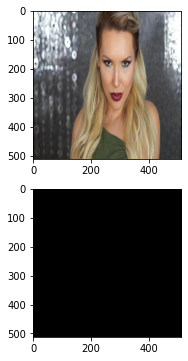

In [115]:
predict_segmentation(os.path.join(dir_train_frame, '00000001.jpg'))

In [ ]:
import pandas as pd

output_metadata = pd.read_csv(os.path.join(os.getcwd(), 'lip','list.csv'))
output_metadata.head(10)
 
new_name_l = []
new_mask_l = []
for row in output_metadata.itertuples():
  new_name = re.split('(\d+)',row.filename)
  new_mask = re.split('(\d+)',row.mask)
  new_name_l.append(new_name[1] + new_name[2])
  new_mask_l.append(new_mask[1] + new_mask[2])

output_metadata.drop(labels = ['filename', 'mask', 'width', 'height', 'class'], axis = 1, inplace = True)
output_metadata['file_name'] = new_name_l
output_metadata['mask'] = new_mask_l


output_metadata.set_index(output_metadata['mask'], inplace = True)
output_metadata.drop(labels = ['mask'], axis = 1, inplace = True)
output_metadata.head()


*   width -----------------> (512/ 1280) * value

*   height ----------------> (512/720) * value




In [ ]:
output_metadata['xmin'] *= (512/ 1280) 
output_metadata['xmax'] *= (512 / 1280)
output_metadata['ymin'] *= (512 / 720)
output_metadata['ymax'] *= (512 / 720)

output_metadata.xmin = output_metadata.xmin.astype(int)
output_metadata.xmax =  output_metadata.xmax.astype(int)
output_metadata.ymin =  output_metadata.ymin.astype(int)
output_metadata.ymax =  output_metadata.ymax.astype(int)

output_metadata.head()

(512, 512, 3)
(512, 512)


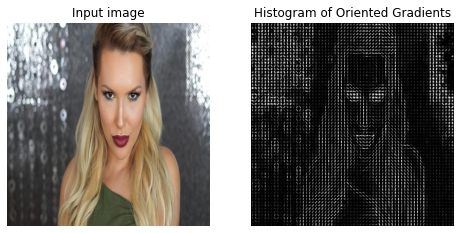

In [82]:
from skimage.feature import hog
from skimage import exposure
image = mpimg.imread(os.path.join(dir_train_frame, '00000001.jpg'))
image = cv.resize(image, (512,512))

image = image


fd, hog_image = hog(image, orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), visualize=True, multichannel=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

print(image.shape)
print(hog_image_rescaled.shape)

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

(512, 512, 3)
<class 'numpy.ndarray'>


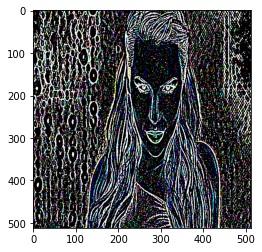

In [90]:
def adjust_gamma(image, gamma = 0.2):
    table = np.array([
                    ((i / 255.0) ** gamma) * 255 for i in np.arange(0,256)
                    ]).astype('uint8')

    return cv.LUT(image, table)

def differnce_of_gaussian_filter(img, kernel_1 = (3,3), kernel_2 = (5,5), sigmoid_1 = 1.0, sigmoid_2 = 2.0):
    low_sigma = cv.GaussianBlur(img, kernel_1, sigmoid_1)
    high_sigma = cv.GaussianBlur(img, kernel_2, sigmoid_2)

    return low_sigma - high_sigma

img = adjust_gamma(image)
img = differnce_of_gaussian_filter(img)
img = img / 255.0
plt.imshow(img)
print(img.shape)
print(type(image))